# 导入模块

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.geocoders import Nominatim

# import seaborn as sns 
#sns.set(style="darkgrid")
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False


from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
import time

import warnings  
warnings.filterwarnings("ignore")

import sys
import pymysql
from sqlalchemy import create_engine
import json
import datetime 
from datetime import timedelta ,time 
import re

import os
import sys
# 获取当前工作目录
current_dir = os.getcwd()
# 将模块所在的目录添加到 sys.path
module_dir = os.path.join(current_dir, '../Class_Model')
sys.path.append(module_dir)
from All_Class import All_Model, Week_Model, Data_Clean

In [71]:

pd.set_option('display.max_columns', None)
# 实例化All_Model类
all_models = All_Model()
week_models = Week_Model()
clean = Data_Clean()

# 定义数据库连接

In [72]:
def query(sql,
          host="rr-wz9wx0w3yti9d4f6wro.mysql.rds.aliyuncs.com",
          user="ylc",
          password="1O8t5lcJ5aMhwwPEUUjS",
          database = '' ,
          port=3306
         ):   
    conn = pymysql.connect(
        host=host,
        user=user,
        port=port,
        password=password,
        max_allowed_packet=1073741824,
        charset="utf8")
    try:
        df = pd.read_sql(sql, con=conn)
        conn.close()
    except:
        print('error')
        conn.close()
        raise
    return df

# 导入订单数据

In [73]:
sql1 = '''   
SELECT date(om.create_time) as create_date,om.create_time,om.id as order_id ,om.order_number,om.all_money 
,om.status
,case om.`status` when  1 then "待支付" when  2 then "待发货" when  3 then "待收货" when  4 then "租赁中" when  5 then "待归还" 
when  6 then "待商家收货" when  7 then "退押中" when  8 then "已完成" when  10 then "已退款" when  11 then "待退押金" when  12 then "待审核" 
when  13 then "订单取消" when  15 then "检测中" when  9999 then "逾期订单" end as status2 
,case when locate('租物',pa.name)>0 or locate('租物',cc.name)>0 or locate('芝麻',pa.name)>0 or locate('芝麻',cc.name)>0  then '芝麻租物' when locate('抖音',pa.name)>0 then '抖音渠道' when locate('搜索',cc.name)>0 then '搜索渠道' else '其他渠道' end as channel_type 
,tod.sku_attributes,tod.product_name,tod.new_actual_money
,case when  locate('租完即送',tod.sku_attributes)>0 then '租完即送' else '租物归还' end as back_type
,om.user_mobile,tmu.true_name,tmu.id_card_num
,top.total_describes,tor.decision_result,om.cancel_reason
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.traceid') end,'"','') as trace_id 
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.rejected') end,'"','') as rejected 
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.result') end,'"','') as result 
,cc.name as channel_name         -- 来源渠道
,pa.name as activity_name        -- 活动名称
,om.merchant_id,om.merchant_name
,topay.total_freeze_fund_amount 
,om.buy_service_product,tso.status as service_status 
,om.order_method, om.has_actual, om.relet_status, om.order_finish_date, om.overdue, tprm.rembursement_status, tprm.purchase_amount
,tol.delivery_province_name, tol.delivery_city_name, tprm.contract_price, tprm.rent_received, tprm.all_rental, tprm.unearned_rent_revenue
from  db_digua_business.t_postlease_receivables_monitoring   tprm
left join db_digua_business.t_order  om on tprm.order_id=om.id
left join db_digua_business.t_order_logistics tol on tol.order_id=om.id
left join db_digua_business.t_merchant tmer on tmer.id = om.merchant_id
left join db_digua_business.t_order_risk tor on om.id = tor.order_id
-- 备注信息合并 
left join ( SELECT  t.order_id,JSON_ARRAYAGG(t.describes) as total_describes from db_digua_business.t_order_personnel t   GROUP BY 1 ) top 
on om.id = top.order_id 
-- 服务信息
left join  db_digua_business.t_service_order tso  on om.id = tso.order_id 
-- 渠道名称
left join db_digua_business.t_channel cc on om.channel = cc.scene 
-- 活动名称
left join db_digua_business.t_platform_activity pa on om.activity_id = pa.id
-- 用户信息 
left join db_digua_business.t_member_user tmu on om.user_id = tmu.id
-- 商品信息
left join db_digua_business.t_order_details tod on om.id = tod.order_id
-- 免押信息  
left join (SELECT t.*,row_number() over(partition by t.order_id order by t.pay_date desc) as rn 
from db_digua_business.t_order_pay t 
where t.pay_type = 'ZFBYSQ' and t.item_type=1 and t.`status` in (2,5) and t.trade_no is not null )  topay 
on topay.order_id=om.id   and  topay.rn = 1 
where om.user_mobile is not null 
and tmu.true_name not in ("刘鹏","谢仕程","潘立","洪柳","陈锦奇","周杰","卢腾标","孔靖","黄娟","钟福荣","邱锐杰","唐林华"
,"邓媛斤","黄子南","刘莎莎","赖瑞彤","孙子文",'张娜','罗文龙','孔靖','彭康力','何薪华','夏玥','潘佳','包闻天','方全龙','李楠','向圆圆','黄兰娟','林婉婷','廖丽敏','李巧玲','李巧凤','刘三妹','蔡斯静' ,'陈宜诗','陈宝易','林寅钗','谢金凤','刘宏生','骆昌鑫','何静', '李珍珍')
-- and COALESCE(pa.name, '未知') not in ("1000单秘密计划","1000单秘密计划-无优惠","1000单曙光计划","线下门店3个月试行") 
-- AND tmer.shop_type !=2  -- 剔除商家
and date_format(om.create_time, '%Y-%m')>='2024-07'
'''

df_order = query(sql1)

In [74]:
# trace关联
sql_trace='''-- trace关联表 
SELECT order_trace_id, trace_id, order_id, order_number, risk_trace_id
from db_credit.order_association
;
'''
trace_df = query(sql_trace)
trace_df.shape

(1521256, 5)

In [75]:
# 蚁盾分
sql_yd = '''
select 
trace_id, score 蚁盾分
from db_credit.risk_antchain
'''
df_yd = query(sql_yd)
df_trace_yd = trace_df.merge(df_yd, on='trace_id', how='left')

# 提取订单风控数据

# 合并数据

In [76]:

df = df_order.copy()
df.order_id.notnull().sum()

np.int64(14759)

# 处理日期

In [77]:
df["下单日期"]=df["create_time"].dt.date
df["下单日期"]=pd.to_datetime(df["下单日期"],errors="coerce")
df["月份"]=df["下单日期"].dt.month
df["下单月份"] = df["create_time"].dt.strftime('%Y-%m')
df.shape


(14759, 44)

In [78]:
df['拒绝理由'] = df["rejected"].str.replace("[","").str.replace("]","").str.replace('"','')

# 处理备注信息

In [79]:
df = df[df['sku_attributes'].notnull()]

In [80]:

df["取消原因"]=df["total_describes"].str.split("客户申请取消：").str[1].str.split("$").str[0].str.strip()
df["电审拒绝原因"]=df["total_describes"].str.split("审核不通过：").str[1].str.split("$").str[0].str.strip()
df["无法联系原因"]=df["total_describes"].str.split("用户无法联系：").str[1].str.split("$").str[0].str.strip()
df.loc[:,"商品类型"]=np.where(df["product_name"].str.contains('99新')|df["product_name"].str.contains('95新')|df["product_name"].str.contains('准新'),"二手","全新")  ##  准新
df.loc[:,"租赁方案"]=np.where(df["sku_attributes"].str.contains('租完即送'),"租完即送","租完归还")
df.loc[:,"押金类型"]=np.where(df["total_freeze_fund_amount"]>0,"部分免押","全免押")
df.loc[:,"优惠券使用否"]=np.where((df["new_actual_money"]-df["all_money"]>0)&(df["租赁方案"]=='租完即送'),"已使用","未使用")
df.loc[:,"是否进行预授权"]=np.where(df["total_freeze_fund_amount"].isnull(),"未预授权","已预授权")

def getcolor(s):
    color_list=json.loads(s)
    for j in range(0,len(color_list)):
        if color_list[j]["key"]=="颜色":
            return color_list[j]["value"]
df.loc[:,"颜色"]=df.apply(lambda x:getcolor(x["sku_attributes"]),axis=1)
df["颜色"].value_counts()  

# %%
def getneicun(s):
    color_list=json.loads(s)
    for j in range(0,len(color_list)):
        if color_list[j]["key"]=="内存":
            return color_list[j]["value"]

df.loc[:,"内存"]=df.apply(lambda x: getneicun(x["sku_attributes"]),axis=1)
df["内存"].value_counts() 

df.loc[:,"进件"]=np.where((df["status2"]=="待支付")|(df["status2"]=="订单取消"),"未进件","进件")
df["进件"].value_counts()

# %%
df.loc[:,"来源渠道"]=df["channel_name"].fillna("未知渠道")

In [81]:
df['免审'] = np.where(df.decision_result.str.contains(pat='免人审',regex=False),1,0)

# 渠道归属

In [82]:
def qudao_type(a,b,c):
    a = str(a)
    b = str(b)
    if "租物" in b:
        return "芝麻租物"
    elif "芝麻" in b:
        return "芝麻租物"
    elif "抖音" in b:
        return "抖音渠道"
    elif "搜索" in a:
        return "搜索渠道"
    elif "租物" in a:
        return "芝麻租物"
    elif "芝麻" in a:
        return "芝麻租物"
    elif c == 1:
        return "芝麻租物"   
    elif "叮咚直播" in a:
        return "叮咚直播"
    elif "租瓜直播2号" in a:
        return "租瓜直播2号"
    elif "租瓜直播" in a:
        return "租瓜直播"
    elif "直播" in a:
        return "支付宝直播"
    elif "繁星" in a:
        return "繁星"
    elif "生活号" in a:
        return "生活号"
    elif "群" in a:
        return "支付宝社群"
    elif "付费灯火" in a:
        return "付费灯火"
    else :
        return a
    

# %%
df.loc[:,"归属渠道"]=df.apply(lambda x:qudao_type(x["来源渠道"],x["activity_name"],x["order_method"]),axis=1)
df["归属渠道"].value_counts()

归属渠道
芝麻租物                         8324
搜索渠道                         4678
单人聊天会话中的小程序消息卡片（分享）           262
我的小程序入口                       240
抖音渠道                          221
八派信息                          202
付费灯火                          142
其他渠道场景渠道。                     105
生活号                            92
支付宝直播                          85
九州信息                           56
付费邦道-首页                        55
付费流量(通过商家数字推广平台，灯火等投放的广告)      43
扫描二维码                          41
支付宝社群                          39
小程序商家消息（服务提醒）                  37
ocpc首页推荐交易                     22
付费邦道-苹果旗舰                      21
未知渠道                           21
小程序快窗                          11
白名单客户                           8
付费邦道-降价了                        8
支付宝 push 消息（同1014）              6
付费侠客行-苹果旗舰                      6
订阅消息                            5
线下易拉宝                           4
美仑美奂                            3
邦道-自定义                          3
系统桌面图标                          3
数立月活A712 

# 订单去重

In [83]:
dict_status_code = {
    "订单取消": 1,
    "待支付": 2,
    "已退款": 3, 
    "待审核": 4,
    "待发货": 5,
    "待收货": 6,
    "租赁中": 7,
    "已完成": 8
}
df["状态编码"]=df["status2"].map(dict_status_code)


df.sort_values(by=["下单日期","状态编码"],inplace=True)


#删除重复单号
df.drop_duplicates(subset=["order_id"],inplace=True)
#删除身份证空值行
df.dropna(subset=["id_card_num"],axis=0,inplace=True)
#去刷单订单
df.drop(df[df['total_describes'].str.contains(pat='panli',regex=False)==True].index,inplace=True)
df.drop(df[df['activity_name']=="1000单秘密计划"].index,inplace=True)
df.drop(df[df['activity_name']=="1000单秘密计划-无优惠"].index,inplace=True)
df.drop(df[df['activity_name']=="1000单曙光计划"].index,inplace=True)
df.drop(df[df['activity_name']=="线下门店3个月试行"].index,inplace=True)
#删除身份证空值行
df.dropna(subset=["status2"],axis=0,inplace=True)


#删除重复订单
df.drop_duplicates(subset=["order_id"],inplace=True)
df.drop_duplicates(subset=["true_name","user_mobile","id_card_num","下单日期"],keep="last",inplace=True)


df.drop(df[df['true_name'].isin(["刘鹏","谢仕程","潘立","洪柳","陈锦奇","周杰","卢腾标","孔靖","黄娟","钟福荣","邱锐杰","唐林华"
,"邓媛斤","黄子南","刘莎莎","赖瑞彤","孙子文"])].index,inplace=True)

# 剔除商家数据

In [84]:
df = clean.drop_merchant(df)

# 定义状态

In [85]:
# 判断 前置拦截   机审强拒   出库前风控强拒
df['是否前置拦截'] = np.where((df.result.str.contains('id_card不得为空') )|(df.result.str.contains('mobile校验不通过')) |(df.result.str.contains('name校验不通过'))
                        |(df.result.str.contains('年龄超过49岁或低于18岁'))|(df.result=='风控未通过')|(df.result=='黑名单用户'),1,0)
df['是否机审强拒'] = np.where((df.result.str.contains('风控拒绝') & (~df.result.str.contains('命中出库前风控流强拒').fillna(False)) ),1,0)
df['是否出库前风控强拒'] = np.where((df.result.str.contains('命中出库前风控流强拒').fillna(False)) |((df.total_describes.str.contains('蚂蚁数控风险等级').fillna(False)) & (~df.result.str.contains('黑名单用户').fillna(False))) ,1,0)


In [86]:

df.loc[:,"审核状态"]=df.apply(lambda x: clean.reject_type(x["拒绝理由"],x["进件"],x["电审拒绝原因"],x["取消原因"],x["status2"],x["无法联系原因"],x["total_describes"],x['是否前置拦截'],x['是否机审强拒'],x['是否出库前风控强拒']),axis=1)

# 去重订单明细导出

In [87]:
from datetime import datetime  
today = datetime.today() 
t_date = today.date().strftime('%Y-%m-%d')
t_date

'2024-12-27'

# 导入服务订单

In [88]:
df["下单时段"]=df["create_time"].astype(str).str[:14]

# %%
df_j = df[df["进件"]=="进件"]
df_j.shape

(13955, 65)

In [89]:
df["待审核"] = np.where(df["审核状态"]=='待审核',1,0)
df["前置拦截"] = np.where(df["审核状态"]=='前置拦截',1,0)
df["机审强拒"] = np.where(df["审核状态"]=='机审强拒',1,0)
df["人审拒绝"] = np.where(df["审核状态"]=='人审拒绝',1,0)
df["客户取消"] = np.where(df["审核状态"]=='客户取消',1,0)
df["出库前风控强拒"] = np.where(df["审核状态"]=='出库前风控强拒',1,0)
df["无法联系"] = np.where(df["审核状态"]=='无法联系',1,0)
df["是否进件"] = np.where(df["进件"]=='进件',1,0)
df["是否出库"] = np.where(df["status"].isin([2,3,4,5,6,8,15]),1,0)

df["进件前取消"] = np.where(df["审核状态"]=='进件前取消',1,0)

In [90]:
df['order_number'].count()

np.int64(13956)

# 导入出库台账数据

In [91]:
#读取导入出库台账数据
f_path_ck = "F:/myfile/p站数据/台账数据/维客壹佰2023&2024年台账.xlsx"
# wb = pd.ExcelFile(f_path_ck)  
# df_ck = pd.read_excel(wb, sheet_name="2023")
df_ck = pd.read_excel(f_path_ck,sheet_name="2023")   #,skiprows=0 header 
df_ck.shape

(26144, 19)

In [92]:
df_ck['溢价费订单'] = "A"+df_ck[df_ck['备注'].str.contains(pat='溢价费',regex=False)==True]['备注'].str.extract('(\d+.\d+)')
df_yijia = df_ck[df_ck['溢价费订单'].str.len()>=16][['溢价费订单',"已付金额"]]
df_yijia=df_yijia.rename(columns={'溢价费订单':"单号","已付金额":"溢价费"})
df_yijia_ck = pd.merge(df_ck,df_yijia,left_on="订单号", right_on="单号",how="left")
dfck = pd.merge(df_yijia_ck,df,left_on="订单号", right_on="order_number")

dfck.drop_duplicates(subset=["订单号"],inplace=True)
dfck.shape#.to_excel(f"C:/Users/Administrator/Desktop/报表模板/出库台账最终整理/11月出库补充1220.xlsx")

(13719, 97)

In [93]:

dfck.drop(dfck[dfck["status2"]=="已退款"].index,inplace=True)

# 删除 露营设备 出库 
dfck.drop(dfck[dfck["类目"]=="露营设备"].index,inplace=True)


# 到期订单

In [94]:

# df0 = pd.crosstab(df["下单月份"],df["rembursement_status"],margins=True)
# df0["逾期率"]=df0["已逾期"]/df0[["已买断","已完成","已逾期","续租中","还款中","检测中"]].apply(lambda x:x.sum(),axis=1)
# df0["逾期率"]=df0["逾期率"].apply(lambda x:format(x,".2%"))
# df0["买断率"]=df0["已买断"]/df0["All"]
# df0["买断率"]=df0["买断率"].apply(lambda x:format(x,".2%"))
# df0["归还率"]=(df0["已完成"]+df0["检测中"])/df0["All"]
# df0["归还率"]=df0["归还率"].apply(lambda x:format(x,".2%"))
# df0["续租率"]=df0["续租中"]/df0["All"]
# df0["续租率"]=df0["续租率"].apply(lambda x:format(x,".2%"))
# 
# df0.rename(columns={'All': '出库'}, inplace=True)

In [95]:
# 定义一个函数来计算年龄
def calculate_age(id_card, order_time):
    birth_year = int(id_card[6:10])
    birth_month = int(id_card[10:12])
    birth_day = int(id_card[12:14])
    birth_date = datetime(birth_year, birth_month, birth_day)
    age = order_time.year - birth_date.year - ((order_time.month, order_time.day) < (birth_date.month, birth_date.day))
    return age

# 应用函数到 DataFrame
df['age'] = df.apply(lambda row: calculate_age(row['id_card_num'], row['create_time']), axis=1)
df_select = df[(df['purchase_amount']>0)&(df['age']>20)]

# 抖音渠道

In [96]:
# 抖音进件数据
df_dy = df[(df.归属渠道=='抖音渠道')&(df.是否进件==1)]

# 性别分布

In [97]:
# 定义一个函数来判断性别
def get_gender(id_card):
    gender_digit = int(id_card[-2])  # 第17位数字
    return '男' if gender_digit % 2 != 0 else '女'

# 应用函数到 DataFrame
df_select['性别'] = df_select['id_card_num'].apply(get_gender)


In [98]:
df_sex = df_select.groupby('性别').agg({'是否出库': 'count'})
df_sex

,是否出库
性别,
女,4338
男,7326


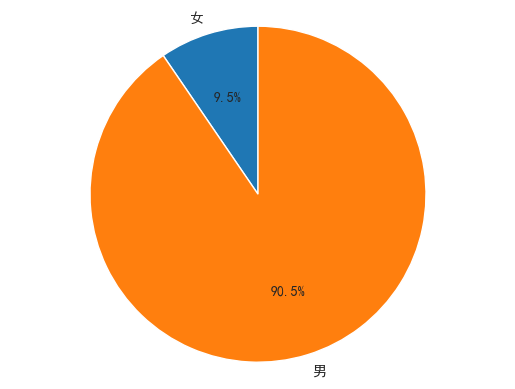

In [99]:
# 抖音渠道
df_dy.loc[:, '性别'] = df.id_card_num.apply(get_gender)
df_dy_group = df_dy.groupby('性别').agg(数量=('order_number', 'count'))#
fig_dy, axis_dy = plt.subplots()
axis_dy.pie(df_dy_group.数量, labels=df_dy_group.index, autopct='%1.1f%%', startangle=90)
axis_dy.axis('equal')
plt.show()

In [100]:
df_dy_group

,数量
性别,
女,21
男,199


# 年龄分布

In [142]:

# 定义年龄区间
age_bins = [0, 22, 25, 30, 35, 40, float('inf')]
age_labels = ['(0,22]', '(22,25]', '(25,30]', '(30,35]', '(35,40]', '[40+)']

# 使用 pd.cut 设置年龄区间 right=True为左开右闭，right=False为左闭右开
df_select['age_group'] = pd.cut(df_select['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=False)

df_age = df_select.groupby('age_group').agg(订单数=('order_number', 'count'))

In [102]:
# 创建饼图
# fig1, aix1 = plt.subplots() # 创建画布
# aix1.pie(df_age['订单数'], labels=df_age.index, autopct='%1.1f%%', startangle=90)
# # 确保饼图是圆形的而不是椭圆的
# aix1.axis('equal') 
# plt.show()

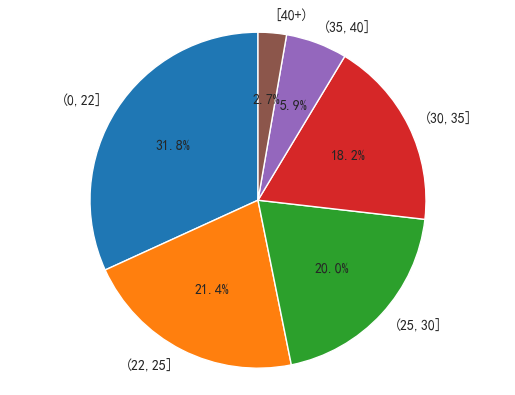

In [143]:
# 抖音
df_dy.loc[:, 'age_group'] = pd.cut(df_dy.age, bins=age_bins, labels=age_labels, right=True, include_lowest=False)
df_dy_group_age = df_dy.groupby('age_group').agg(订单数=('order_number', 'count'))
fig_dy, axis_dy = plt.subplots()
axis_dy.pie(df_dy_group_age.订单数, labels=df_dy_group_age.index, autopct='%1.1f%%', startangle=90)
axis_dy.axis('equal')
plt.show()

# 地域分布

In [104]:
df_select = df_dy.copy()

df_province1 = pd.crosstab(df_select["下单月份"],df_select["delivery_province_name"],margins=True)

df_select['delivery_province_name'] = np.where(df_select['delivery_province_name']=='上海', '上海市', 
                                        np.where(df_select['delivery_province_name']=='北京', '北京市',
                                                np.where(df_select['delivery_province_name']=='天津', '天津市',
                                                        np.where(df_select['delivery_province_name']=='重庆', '重庆市', df_select['delivery_province_name']))))
province_list = ['广东省', '江苏省', '浙江省', '福建省', '山东省', '四川省', '河南省', '河北省', '安徽省', '云南省', '湖北省', '湖南省', '江西省', '陕西省', '上海市', '辽宁省', 
                '北京市', '重庆市', '贵州省', '广西壮族自治区', '山西省', '黑龙江省', '吉林省', '甘肃省', '天津市', '海南省']
df_delivery_province_name = df_select.groupby('delivery_province_name').agg({'是否出库': 'count'})
# df_delivery_province_name

In [135]:
df_select_delivery = df_select.groupby(['delivery_province_name', 'delivery_city_name']).agg(订单数=('order_number', 'count')).sort_values('订单数', ascending=False)[:10]
df_select_deliverys = df_select.groupby(['delivery_province_name']).agg(订单数=('order_number', 'count')).sort_values('订单数', ascending=False)

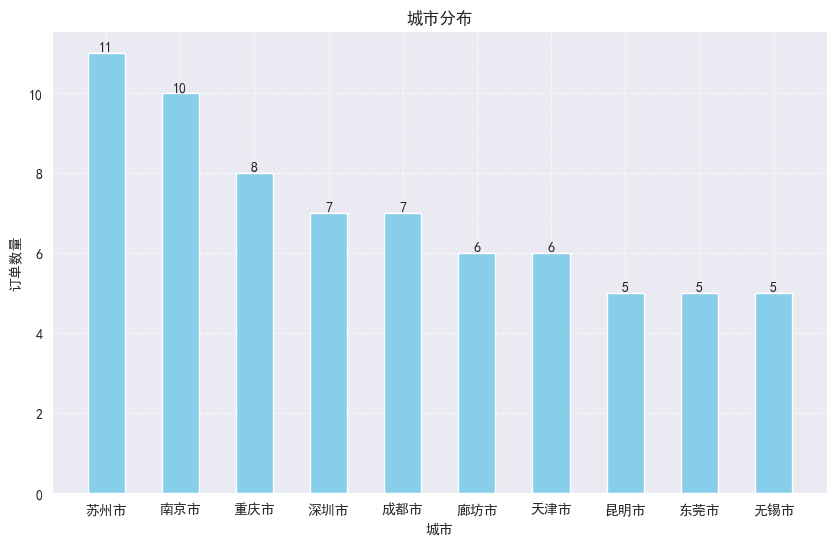

In [106]:
df_select_delivery = df_select_delivery.reset_index() 
# 创建柱形图
plt.figure(figsize=(10, 6)) # 图形大小
# 绘制柱形图
bars = plt.bar(x=df_select_delivery['delivery_city_name'], height=df_select_delivery['订单数'], color='skyblue', width=0.5)  # 设置颜色和柱宽
# 添加数据标签到每个柱子上
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    
# 设置图表标题和坐标轴标签
plt.title('城市分布')
plt.xlabel('城市')
plt.ylabel('订单数量')
# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

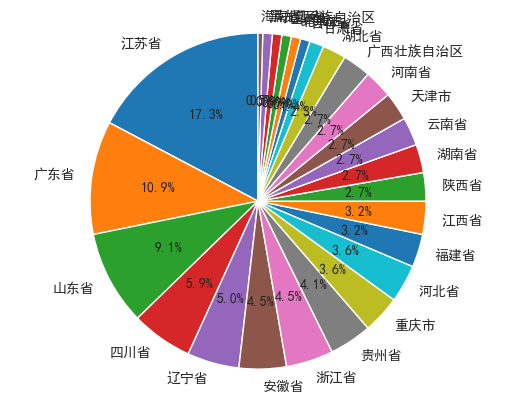

In [141]:
fig2, aix2 = plt.subplots()
aix2.pie(df_select_deliverys['订单数'], labels=df_select_deliverys.index, autopct='%1.1f%%', startangle=90)
aix2.axis('equal')
plt.show()

# 蚁盾分

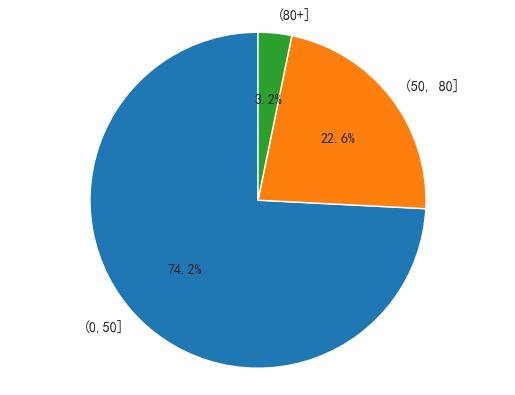

In [134]:
df_dy_merge = df_dy.merge(df_trace_yd[['order_id', '蚁盾分']], on='order_id', how='left')
df_dy_merge[df_dy_merge.蚁盾分.isna()].order_number.count()
df_dy_merge = df_dy_merge[df_dy_merge.蚁盾分.notna()]
df_dy_merge['蚁盾分'] = df_dy_merge.蚁盾分.astype(float)


yd_bins = [0.0, 50.0, 80.0, float('inf')]
yd_labels = ['(0,50]', '(50, 80]', '(80+]']
df_dy_merge.loc[:, 'group'] = pd.cut(df_dy_merge['蚁盾分'], bins=yd_bins, labels=yd_labels, right=True, include_lowest=False)
df_dy_merge[['order_number', '蚁盾分', 'group']]
df_dy_merge_group = df_dy_merge.groupby('group').agg(score=('order_number', 'count'))
fig1, axis_yd = plt.subplots()
axis_yd.pie(df_dy_merge_group['score'], labels=df_dy_merge_group.index, autopct='%1.1f%%', startangle=90)
axis_yd.axis('equal')
plt.show()

# 前15出库机型

In [33]:
def xinghao_classify(a,b):
    if 'iphone15promax' in a:
        return 'iphone15promax'
    elif 'iphone14promax' in a:
        return 'iphone14promax'
    elif 'iphone16promax' in a:
        return 'iphone16promax'
    elif 'iphone15pro' in a:
        return 'iphone15pro'    
    elif 'iphone14pro' in a:
        return 'iphone14pro'
    elif 'iphone16pro' in a:
        return 'iphone16pro'
    elif 'iphone15plus' in a:
        return 'iphone15plus'
    elif 'iphone16plus' in a:
        return 'iphone16plus'  
    elif 'iphone15' in a:
        return 'iphone15' 
    elif 'iphone14' in a:
        return 'iphone14'
    elif 'iphone16' in a:
        return 'iphone16'
    elif 'mate60pro' in a:
        return 'mate60pro'
    elif 'iphone11' in a:
        return 'iphone11'
    elif 'vivoiqoo9pro' in a:
        return 'vivoiqoo9pro'
    elif 'vivox80' in a:
        return 'vivox80'
    elif 'vivoy55s' in a:
        return 'vivoy55s'
    elif 'iphone14plus' in a:
        return 'iphone14plus'
    elif 'iphone13promax' in a:
        return 'iphone13promax'
    elif 'mate60' in a:
        return 'mate60'
    elif 'watch' in a:
        return 'watch'
    elif 'iphone13pro' in a:
        return 'iphone13pro'
    elif 'vivox100pro' in a:
        return 'vivox100pro'
    elif '小米13pro' in a:
        return '小米13pro'
    elif '小米13' in a:
        return '小米13'
    elif 'iphone12promax' in a:
        return 'iphone12promax'
    elif 'iphone13' in a:
        return 'iphone13'
    elif '小米14pro' in a:
        return '小米14pro'
    elif '小米14' in a:
        return '小米14'
    elif 'iphone12pro' in a:
        return 'iphone12pro'
    elif 'ipad' in a:
        return 'ipad'
    elif 'iphone12' in a:
        return 'iphone12'
    elif '相机' in a:
        return '相机'
    elif '荣耀x50' in a:
        return '荣耀x50'
    elif 'findx6pro' in a:
        return 'findx6pro'
    elif 'xiaomi13' in a:
        return '小米13'
    elif 'vivoiqoo12pro' in a:
        return 'vivoiqoo12pro'
    elif 'oppofindn2' in a:
        return 'oppofindn2'
    elif 'redminote12turbo' in a:
        return 'redminote12turbo'
    elif 'iqoo11' in a:
        return 'iqoo11'
    elif 'vivox100' in a:
        return 'vivox100'
    elif 'mate50pro' in a:
        return 'mate50pro'
    elif 'x90' in a:
        return 'x90'
    elif 'vivoiqooneo8' in a:
        return 'vivoiqooneo8'
    elif '华为pura70pro' in a:
        return '华为pura70pro'
    elif '华为p60' in a:
        return '华为p60'
    elif 'vivoiqoo12' in a:
        return 'vivoiqoo12'
    elif 'x90pro' in a:
        return 'x90pro'
    elif '华为pura70' in a:
        return '华为pura70'
    elif 'iqooneo8pro' in a:
        return 'iqooneo8pro'
    elif 'vivot2x' in a:
        return 'vivot2x'
    elif 'oppofindx7ultra' in a:
        return 'oppofindx7ultra'
    elif 'vivoiqoo9' in a:
        return 'vivoiqoo9'
    elif 'vivoiqooneo6' in a:
        return 'vivoiqooneo6'
    elif 'magic4' in a:
        return 'magic4'
    elif 'iphone8plus' in a:
        return 'iphone8plus'
    elif 'opporeno8pro+' in a:
        return 'opporeno8pro+'
    elif '华为nova11pro' in a:
        return '华为nova11pro'
    elif 'realme真我gtneo3' in a:
        return 'realme真我gtneo3'
    elif 'vivos15' in a:
        return 'vivos15'
    elif 'vivoy76s' in a:
        return 'vivoy76s'
    elif '荣耀x40' in a:
        return '荣耀x40'
    else :
        return b

df['型号1'] = df.product_name.str.lower().str.replace(' ','')
# df.型号1.value_counts()

df.loc[:,"型号_new"] = df.apply(lambda x:xinghao_classify(x["型号1"],x['product_name']),axis=1)
df["型号_new"].value_counts()

型号_new
iphone16promax                                1365
iphone16pro                                    423
iphone15promax                                 335
iphone16                                        92
iphone15pro                                     91
iphone15                                        50
iphone16plus                                    38
华为pura70pro                                     12
天语X80pro 全新国行 128G                              11
OPPO A3x 全新国行 6GB+128GB                         10
ipad                                            10
iphone15plus                                     7
全新小米15 徕卡光学Summilux高速镜头 5G手机 顺丰包邮                5
全新小米15Pro 徕卡光学Summilux高速镜头 5g手机 顺丰包邮             4
iphone14promax                                   3
vivox100                                         3
全新OPPO FindX8 无影抓拍 超轻薄直屏 AI一键问屏 顺丰包邮             3
vivo X200Pro 【首月1元】蔡司2亿APO超级长焦 顺丰包邮              3
watch                                            3
华为pura70                

In [34]:
df_ck = df[df['是否出库']==1]
df.groupby('型号_new').agg({'是否出库': 'sum'}).sort_values(by='是否出库', ascending=False)[:15]
df.groupby('型号_new').agg({'是否出库': 'sum'}).to_excel('F:/xxxxxxxxxxxxxxxx.xlsx')

In [35]:
def product(df):
    df['型号'] = df['product_name'].str.extract(r'(iPhone ?\d+ ?(ProMax|Pro|Plus)?)'
                                            r'|(华为 ?(Mate|Pura|畅享|P|nova) ?\d+ ?(Pro\+|Pro|Plus\+|Plus|Flip\+|Flip)?|nova ?\d+ ?(Pro\+|Pro|Ultra\+|Ultra|Flip\+|Flip)?|华为 ?nova ? Flip?)'
                                            r'|(OPPO ?(Find|Reno|A|K|R) ?)', expand=True)[0]

In [36]:
df['是否出库'].sum()

np.int64(2470)